# Building makemore Part 2: MLP

Youtube video link [here](https://www.youtube.com/watch?v=TCH_1BHY58I)

Paper referenced in the video, called [A Neural Probabilistic Language Model by Bengio et al.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

Makemore library reference [here](https://github.com/karpathy/makemore)

## Lecture notes



### The high-level NN architecture from the paper
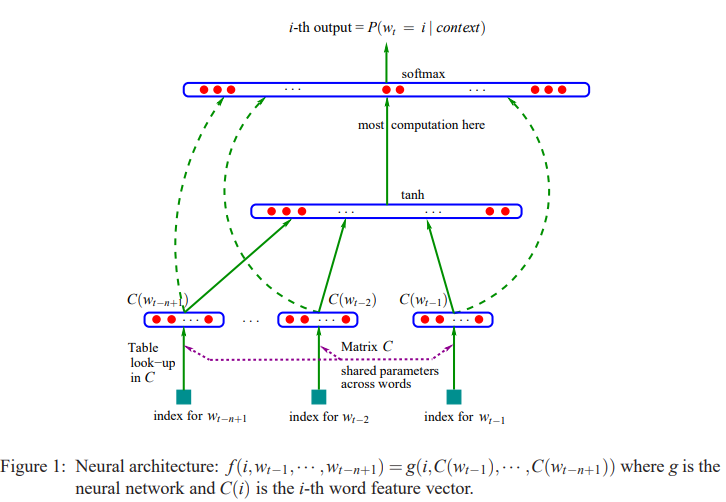ms

### Building the dataset

In [366]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import time # Ege's addition for timing the iteration speed
%matplotlib inline

In [367]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [368]:
len(words)

32033

In [369]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [370]:
# build the dataset - first 5 words as an example

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [371]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In the Bengio example, they reduce 20K words into a 30-dimensional vector space.

We want to do the same for representing our 27-char alphabet into 2-dimensional embeddings.

In [372]:
C = torch.randn((27,2))

You could technically do this via one-hot encoding using `F.one_hot` but it is more inefficient. So we are going with this approach instead.

### Pytorch indexing to speed up the process

You can use a tensor to index which is much faster. We will use this to create embeddings.

In [373]:
X[13,2]

tensor(1)

In [374]:
C[X][13,2]

tensor([0.4184, 0.4312])

In [375]:
C[1]

tensor([0.4184, 0.4312])

In [376]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [377]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

We want to do `emb @ W1 + b1` but it does not work due to the shape of `emb`.

In [378]:
# first get the embeddings for the word
emb[:, 0, :].shape

torch.Size([32, 2])

In [379]:
# we can use torch.cat to concatenate them
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [380]:
# we do have a torch.unbind method to unbind along a dimension
len(torch.unbind(emb, 1))

3

In [381]:
# this is the generalized version of above that becomes independent of the block size
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

#### Side content: how the internals of Pytorch work

More details on this blog post called [PyTorch Internals by Edward Z. Yang](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [382]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [383]:
a.shape

torch.Size([18])

In [384]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [385]:
# This method is super efficient due to how it is stored and how it is viewed are separate
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

Relevant bit from the blog:

![image.png](http://blog.ezyang.com/img/pytorch-internals/slide-07.png)

How is this relevant? we can use the `view` function to do the same as above, but much more efficiently

In [386]:
A = emb.view(32,6)
A.shape

torch.Size([32, 6])

In [387]:
B = torch.cat(torch.unbind(emb, 1), 1)
B.shape

torch.Size([32, 6])

In [388]:
# check that they are equivalent
# emb.view(32,6) == torch.cat(torch.unbind(emb, 1), 1).shape


# The example in the video returns False, i think it is no longer 
# found that isclose is a better check for element-wise equality
# Details: https://pytorch.org/docs/stable/generated/torch.isclose.html
torch.isclose(A, B)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

### Back to creating the hidden layer

We can use the view method to perform the weight and bias operation we wanted:

In [389]:
# using -1 makes it the actual size of emb.shape[0]
h = emb.view(-1,6) @ W1 + b1
h

tensor([[-1.9688, -3.4546, -2.9655,  ...,  5.6583, -1.3777, -0.7669],
        [-0.6653, -2.4462, -3.7266,  ...,  0.8775, -2.8903, -1.0309],
        [-1.9641, -4.2931, -3.9368,  ...,  4.9212,  1.2763, -0.2941],
        ...,
        [ 7.4409, -3.9057, -3.2946,  ...,  3.7322,  1.9346,  1.0715],
        [-0.3724, -2.9027, -3.1467,  ...,  3.5273, -3.2194,  1.6859],
        [-0.6043, -0.7132, -1.3112,  ...,  2.2255, -2.2171,  0.5417]])

In [390]:
h.shape

torch.Size([32, 100])

In [391]:
# Since we want this as part of our hidden layer of activation, we want to apply tanh to map these values between -1 and 1

h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[-0.9618, -0.9980, -0.9947,  ...,  1.0000, -0.8804, -0.6451],
        [-0.5819, -0.9851, -0.9988,  ...,  0.7052, -0.9938, -0.7743],
        [-0.9614, -0.9996, -0.9992,  ...,  0.9999,  0.8555, -0.2859],
        ...,
        [ 1.0000, -0.9992, -0.9973,  ...,  0.9989,  0.9591,  0.7900],
        [-0.3561, -0.9940, -0.9963,  ...,  0.9983, -0.9968,  0.9336],
        [-0.5401, -0.6127, -0.8646,  ...,  0.9769, -0.9766,  0.4943]])

Remember to check the broadcasting is applied correctly when adding `b1` to the matrix product

* `emb @ W1` is \[32, 100]
* `b1` is \[100], which becomes \[1,100] since broadcasting is right-aligned
* Thus it applies the b1 row vector on every single one of 32 rows in emb

### Creating the output layer

In [392]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [393]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [394]:
counts = logits.exp()
counts[0]

tensor([3.5374e-02, 3.4089e+00, 3.6020e-05, 5.0287e+01, 5.2312e+05, 6.1141e+01,
        1.8237e-04, 2.0021e-02, 4.8341e+02, 6.6568e-02, 4.7986e+03, 3.1629e+06,
        1.3430e-02, 1.8244e+03, 6.7170e-06, 8.2101e-01, 5.3059e+00, 1.7244e+01,
        2.3982e+05, 7.6423e+01, 3.2101e+04, 5.0052e+02, 3.0839e+03, 4.1502e+06,
        6.4617e-03, 6.7462e-06, 5.3253e-07])

In [395]:
prob = counts / counts.sum(1, keepdims =True)
prob.shape

torch.Size([32, 27])

In [396]:
# get the prob of observing Y for each row given our current setting
prob[torch.arange(32), Y]

tensor([7.5306e-06, 2.7102e-10, 9.4212e-06, 7.4968e-16, 5.7151e-15, 1.0112e-07,
        3.0453e-07, 5.4551e-10, 2.3778e-14, 7.2657e-06, 4.1059e-05, 2.9077e-06,
        4.1987e-07, 1.1138e-03, 2.9607e-06, 2.6249e-08, 8.1990e-09, 1.3014e-03,
        3.8715e-06, 1.0101e-06, 1.5145e-01, 1.6673e-12, 1.3297e-12, 7.6259e-14,
        3.5860e-19, 9.4129e-06, 3.7143e-08, 9.1219e-01, 6.2607e-10, 4.1084e-08,
        4.2324e-05, 3.0779e-09])

In [397]:
# get the avg neg log likelihood, which is what we want to minimize
-prob[torch.arange(32), Y].log().mean()

tensor(17.5120)

### Switching to the respectable version :)


In [398]:
X.shape, Y.shape #dataset

(torch.Size([32, 3]), torch.Size([32]))

In [399]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [400]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [401]:
# current forward pass
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
# Prev:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims =True)
# loss = -prob[torch.arange(32), Y].log().mean()
# We have a faster way: cross entropy
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [402]:
for p in parameters:
    p.requires_grad = True

In [403]:
learning_rate = 0.1
# full loop
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad

17.76971435546875
13.656401634216309
11.298768997192383
9.452455520629883
7.984262466430664
6.891321182250977
6.100014686584473
5.452036380767822
4.898151874542236
4.414664268493652


### With the full dataset

In [404]:
# build the dataset - first 5 words as an example

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [405]:
X.shape, Y.shape #dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [406]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [407]:
for p in parameters:
    p.requires_grad = True

In [408]:
learning_rate = 0.1
# full loop
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad

19.505229949951172
17.084491729736328
15.776533126831055
14.833342552185059
14.002605438232422
13.253263473510742
12.57991886138916
11.983101844787598
11.47049331665039
11.05185604095459


Works but is significantly slower since we now have 228k items we are passing. To alleviate that, we should use minibatches

### Minibatching

In [409]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [410]:
learning_rate = 0.1
batch_size = 32
# full loop
for _ in range(1000):
    # MINIBATCHING
    ix = torch.randint(0, X.shape[0], (batch_size,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
print(loss.item())

2.82057523727417


In [411]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.7242472171783447


### How to determine a good initial learning rate

You can play around with the `learning_rate` above to see 1 is too much and 0.001 is too little. So how do we find what is "good"?

In [412]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [413]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [414]:
batch_size = 32
lri = []
lossi = []
# full loop
for i in range(1000):
    # MINIBATCHING
    ix = torch.randint(0, X.shape[0], (batch_size,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    learning_rate = lrs[i]
    for p in parameters:
        p.data += -learning_rate * p.grad
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
print(loss.item())

7.600299835205078


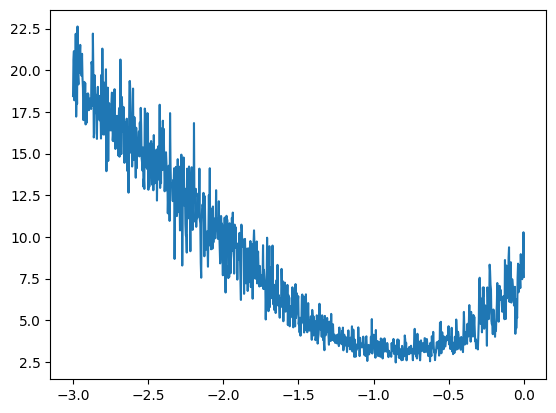

In [415]:
plt.plot(lri, lossi)

The valley here corresponds to roughly -1, which would mean that the ideal learning rate is close to 10**-1, which is 0.1.

In [416]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [417]:
learning_rate = 0.1
batch_size = 32
# full loop
for _ in range(10000):
    # MINIBATCHING
    ix = torch.randint(0, X.shape[0], (batch_size,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
print(loss.item())

2.1507906913757324


In [418]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.4721755981445312


In [419]:
# do a learning rate decay
learning_rate = 0.01
batch_size = 32
# full loop
for _ in range(10000):
    # MINIBATCHING
    ix = torch.randint(0, X.shape[0], (batch_size,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
print(loss.item())

2.141446828842163


In [420]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.3968141078948975


### Splitting the data into train, dev/val, test splits 

Usually 80-10-10% to avoid overfitting and optimizing hyperparameters.

In [421]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [422]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [423]:
# now use the Xtr and Ytr to train
learning_rate = 0.1
batch_size = 32
# full loop
for _ in range(10000):
    # MINIBATCHING
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
print(loss.item())

2.5029091835021973


In [424]:
# evaluate on Xdev and Ydev
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.494655132293701


In [425]:
# compare that to Xtr and Ytr loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.4992971420288086


These two losses being two close means that **we are currently underfitting the data** and that we have room to scale our NN.

### Scaling up the NN

In [426]:
# bumping up the hidden layer to 300 from 100
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [427]:
sum(p.nelement() for p in parameters) # number of parameters in total is now a lot higher

10281

In [428]:
# tracking the step number too
learning_rate = 0.1
batch_size = 32
lossi = []
stepi = []
# full loop
for i in range(30000):
    # MINIBATCHING
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    # tracking added back
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

2.5124785900115967


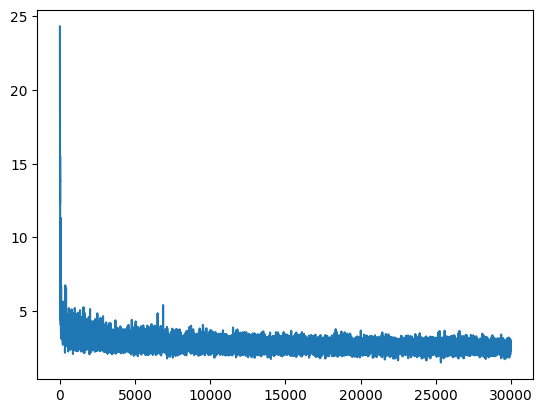

In [429]:
# show how the loss minimization is working over the training cycle
plt.plot(stepi, lossi)

In [430]:
# evaluate on Xdev and Ydev
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.6032590866088867


In [431]:
# compare that to Xtr and Ytr loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.596259832382202


Still way too close...

We will try changing the learning rate and running it a few more times:

In [432]:
# decrease the learning rate
learning_rate = 0.01
batch_size = 32
lossi = []
stepi = []
# full loop
for i in range(30000):
    # MINIBATCHING
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    # tracking added back
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

2.2372636795043945


In [433]:
# evaluate on Xdev and Ydev
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.2973310947418213


In [434]:
# compare that to Xtr and Ytr loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.2936367988586426


### Potential Bottleneck #1 - vector space being too limiting

Maybe the two dimentional embeddings are losing too much of the fidelity?

First, let\'s visualize what we have.

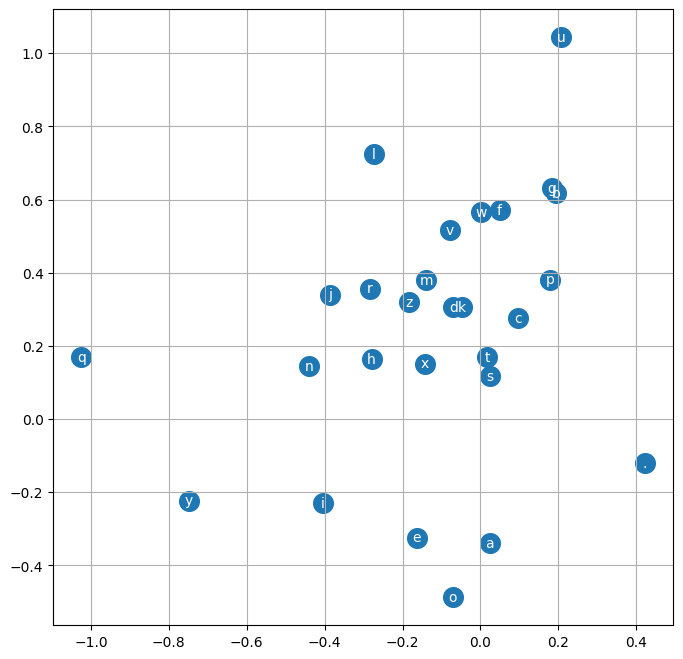

In [435]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [436]:
# bumping up the embedding size to 10 from 2
# also dropping the hidden layer size to 200
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [437]:
sum(p.nelement() for p in parameters) # number of parameters in total is now a lot higher

11897

In [438]:
lossi = []
stepi = []

In [439]:
# tracking the step number too
learning_rate = 0.1
batch_size = 32

# full loop
for i in range(50000):
    # MINIBATCHING
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    # tracking added back
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.177908182144165


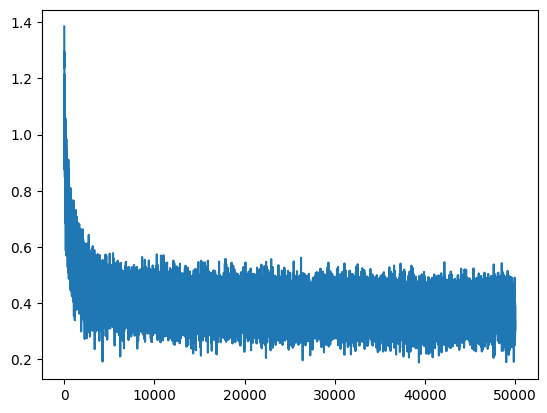

In [440]:
# now we show the log loss instead to make it look cleaner
plt.plot(stepi, lossi)

In [441]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.3135313987731934
Dev loss:  2.3284599781036377


In [442]:
# now lowering the LR
learning_rate = 0.01
batch_size = 32

# full loop
for i in range(50000):
    # MINIBATCHING
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    # tracking added back
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.407320499420166


In [443]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.185309410095215
Dev loss:  2.20955228805542


### Putting it all together

In [444]:
# bumping up the embedding size to 10 from 2
# also dropping the hidden layer size to 200
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [445]:
lossi = []
stepi = []

In [446]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

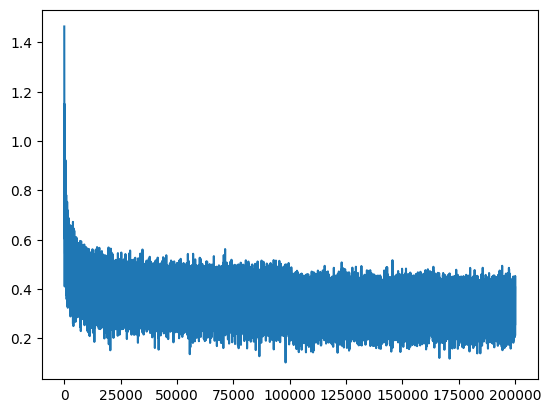

In [447]:
# now we show the log loss instead to make it look cleaner
plt.plot(stepi, lossi)

In [448]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.118727207183838
Dev loss:  2.166417360305786


### Bonus - sampling from the model

In [449]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
seel.
nihaham.
remmrstendraeg.
adeerdoelin.
shi.
jenre.
elieananar.
kayzion.
kamin.
shurergahimiel.
kendreelyn.
xeberley.
brey.
dariyah.
fael.
yuma.
myson.
daihaan.


## Exercises

- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [450]:
# all hyperparams
block_size = 3
vector_dim = 10
hidden_layer_inputs = block_size * vector_dim #30 initially
hidden_layer_size = 200

### E01 - hyperparameter tuning to beat the Karpathy loss of 2.2

#### Idea #1 - change block size

In [451]:
# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 5]) torch.Size([182580])
torch.Size([22767, 5]) torch.Size([22767])
torch.Size([22799, 5]) torch.Size([22799])


In [452]:
# make it a bit more modular with explicit hyperparams
vector_dim = 10
hidden_layer_inputs = block_size * vector_dim #30 initially
hidden_layer_size = 200
batch_size = 32
num_iterations = 200000

In [453]:
# now plug in the numbers
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, vector_dim), generator=g)
W1 = torch.randn((hidden_layer_inputs, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [454]:
sum(p.nelement() for p in parameters) # number of parameters in total is now a lot higher

15897

In [455]:
lossi = []
stepi = []

In [456]:
start = time.time()
for i in range(num_iterations):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, hidden_layer_inputs) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
end = time.time()
print("Runtime: ", end - start)
print("Loss: ", loss.item())

Runtime:  85.85059881210327
Loss:  2.2525055408477783


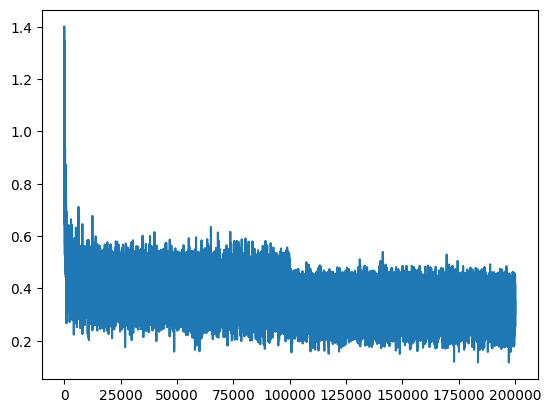

In [457]:
# now we show the log loss instead to make it look cleaner
plt.plot(stepi, lossi)

In [458]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.1883418560028076
Dev loss:  2.209678888320923


#### Idea #2 - change batch size

32 was a very random number anyway, let's update it. Keeping the increased context window for now.

In [459]:
# define the hyperparams
vector_dim = 10
hidden_layer_inputs = block_size * vector_dim #30 initially
hidden_layer_size = 200
batch_size = 128
num_iterations = 200000

In [460]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, vector_dim), generator=g)
W1 = torch.randn((hidden_layer_inputs, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [461]:
# reset loss & step trackers
lossi = []
stepi = []

In [462]:
start = time.time()
for i in range(num_iterations):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, hidden_layer_inputs) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
end = time.time()
print("Runtime: ", end - start)
print("Loss: ", loss.item())

Runtime:  115.36665105819702
Loss:  2.0203661918640137


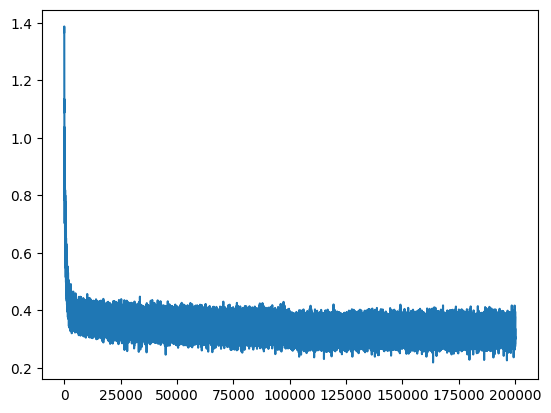

In [463]:
# now we show the log loss instead to make it look cleaner
plt.plot(stepi, lossi)

In [464]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.132655620574951
Dev loss:  2.1529719829559326


We are already beating his benchmark but I want to test it further

#### Idea #3 - original block size, but larger batches, more neurons, and smoother change in learning rate

I wanted to test a mixed model of:
* bringing back the block size of 3
* updating the hidden layer to have 300 neurons
* increasing the batch size to 256
* adding a stepwise transition that starts the learning rate at 0.1 then halves it at every 50k steps (made it modular to make it easier to update)

In [465]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [466]:
# make it a bit more modular with explicit hyperparams
vector_dim = 10
hidden_layer_inputs = block_size * vector_dim #30 initially
hidden_layer_size = 300
batch_size = 256
num_iterations = 200000
decay_steps = 4

In [467]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, vector_dim), generator=g)
W1 = torch.randn((hidden_layer_inputs, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [468]:
# reset loss & step trackers
lossi = []
stepi = []

In [469]:
import math

start = time.time()
initial_lr = 0.1
step_points = num_iterations / decay_steps

for i in range(num_iterations):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, hidden_layer_inputs) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  lr_update_factor = max(1, math.ceil(i / step_points))
  # update
  #lr = lrs[i]
  lr = initial_lr / lr_update_factor
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
end = time.time()
print("Runtime: ", end - start)
print("Loss: ", loss.item())

Runtime:  172.51187086105347
Loss:  2.1173272132873535


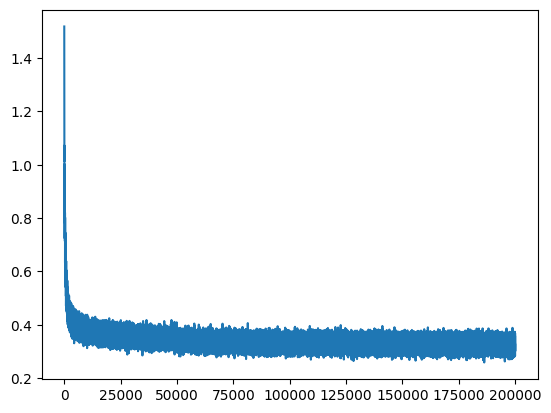

In [470]:
# now we show the log loss instead to make it look cleaner
plt.plot(stepi, lossi)

In [471]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.122081756591797
Dev loss:  2.1832096576690674


This enabled me to get batch losses below 2 and helped get the best training loss so far. 

The divergence between the training and dev indicates that I am starting to overfit on training, so tuning the hyperparameters for lower batch size and/or fewer iterations seems promising.